# Statistics of Master-HEAD

In [1]:
import json, re, pprint, os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('pgf') # this makes exports more beautiful, but disables plots in this notebook

FOLDER='stable-spark18pro-latest'

pltsettings = {
    "figure.figsize" : (5.0, 4.0),
    "pgf.texsystem" : "pdflatex",
    "font.family": "serif",
    "font.serif": [],                   # use latex default serif font
    #"font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pltsettings)

import matplotlib.pyplot as plt
#import seaborn as sns # makes exports ugly

In [2]:
def read_json(fname):
    """
    reads JSOn and returns (totals, units), tuple of dicts
    """
    units=None
    totals=None
    with open(fname,'r') as f:
        endofunits = False
        for line in f:
            match = re.search(r'^TOTALS', line)        
            if match:                
                endofunits = True
            if not endofunits:
                try:
                    if not units:
                        units = json.loads(line)
                    else:
                        print "error: units appearing multiple times"
                except:
                    pass
            else:
                try:
                    if not totals:
                        totals = json.loads(line)
                    else:
                        print "error: totals appearing multiple times"
                except:
                    pass
    # unpack units (list of dicts) => dict
    tmp=units
    units={}
    for u in tmp:
        name=u.keys()[0]
        stats=u[name]
        #print "unit="+name +", stats=" + str(stats)
        units[name]=stats       
    return (totals, units)
            
#######
(totals, units) = read_json(FOLDER + os.sep + 'unitstats-json-detail.log')
print "TOTALS: "
pprint.pprint(totals)
print "UNITS: "
u0 = units.keys()[0]
print u0 + ": "+ str(units[u0])


TOTALS: 
{u'ent_cov': 55.89941972920696,
 u'ents': 1551,
 u'flows': 1648,
 u'flows_proven': 1593,
 u'flows_success': 96.6626213592233,
 u'flows_suppressed': 29,
 u'props': 2060,
 u'proven': 1768,
 u'rules': {u'ALIASING': {u'cnt': 16, u'proven': 16},
            u'UNINITIALIZED': {u'cnt': 1632, u'proven': 1577},
            u'VC_ASSERT': {u'cnt': 15, u'proven': 12},
            u'VC_CEILING_PRIORITY_PROTOCOL': {u'cnt': 2, u'proven': 2},
            u'VC_CONTRACT_CASE': {u'cnt': 4, u'proven': 4},
            u'VC_DISCRIMINANT_CHECK': {u'cnt': 65, u'proven': 64},
            u'VC_DISJOINT_CONTRACT_CASES': {u'cnt': 1, u'proven': 1},
            u'VC_DIVISION_CHECK': {u'cnt': 70, u'proven': 68},
            u'VC_FP_OVERFLOW_CHECK': {u'cnt': 429, u'proven': 233},
            u'VC_INDEX_CHECK': {u'cnt': 42, u'proven': 42},
            u'VC_LENGTH_CHECK': {u'cnt': 178, u'proven': 171},
            u'VC_OVERFLOW_CHECK': {u'cnt': 89, u'proven': 71},
            u'VC_POSTCONDITION': {u'cnt': 24, 

## Property Occurence

/home/becker/bin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


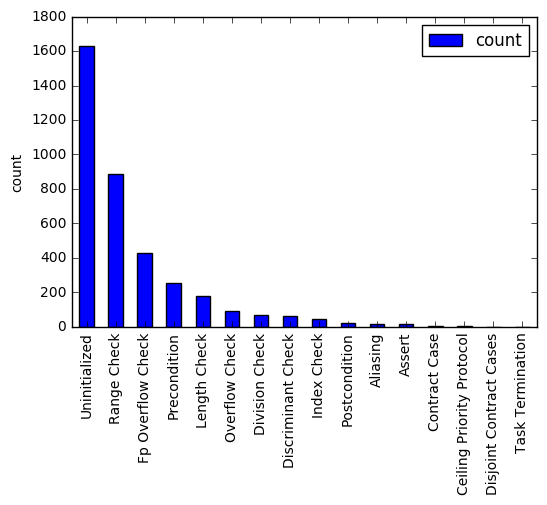

In [3]:
# plot success per VC type; rows are VCs, columns are "success", "fail"
def pretty_vcname(VCname):
    parts = VCname.split("_");
    if parts[0] == "VC":
        parts = parts[1:]    
    return " ".join(parts).title()

counters={pretty_vcname(k) : v['cnt'] for k,v in totals["rules"].iteritems()}
df_cnt = pd.DataFrame(counters,index=['count']).T
#print df2.head()
# sort by occurence
df_cnt.sort_values(by='count', ascending=False, inplace=True)
ax=df_cnt.plot.bar();
ax.set_ylabel('count')
plt.savefig(FOLDER + os.sep + 'props.pdf', bbox_inches='tight')
plt.show()

## Success Ratio of Properties (Normalized)

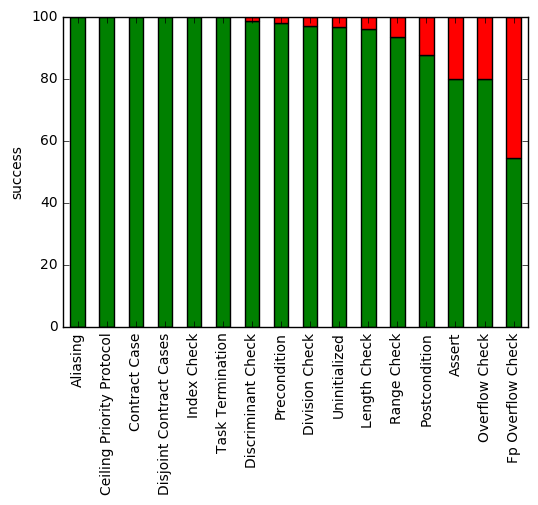

In [4]:
# plot success per VC type; rows are VCs, columns are "success", "fail"
VCs={pretty_vcname(k) : {'proven' : 100.0*v['proven'] / v['cnt'], 'unsuccessful': 100.0*(v['cnt']-v['proven'])/v['cnt'] } for k,v in totals["rules"].iteritems()}
df2 = pd.DataFrame(VCs).T
#print df2.head()
df2.sort_values(by='proven', inplace=True, ascending=False)
ax=df2.plot.bar(stacked=True,color=['green','red'],legend=False);
ax.set_ylabel('success')

plt.savefig(FOLDER + os.sep + 'vc_success.pdf', bbox_inches='tight')
plt.show()

## Success Ratio by unit

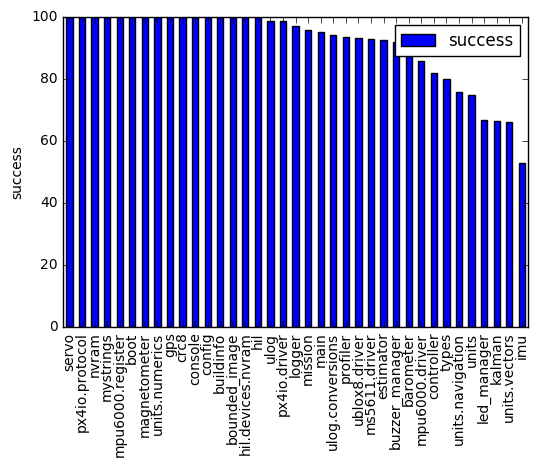

In [5]:
unit_success = {k : {'success': v['success'], 'cnt' : v['props']} for k,v in units.iteritems()}
df_usucc = pd.DataFrame(unit_success).T
df_usucc.sort_values(by='success', inplace=True, ascending=False)
exclude_columns=['cnt']
ax=df_usucc.ix[df_usucc.cnt>0,df_usucc.columns.difference(exclude_columns)].plot.bar();
ax.set_ylabel('success')
plt.show()

                 cnt  proven     success  unsuccessful
barometer       11.0    10.0   90.909091           1.0
boot             2.0     2.0  100.000000           0.0
bounded_image   35.0    35.0  100.000000           0.0
buildinfo       16.0    16.0  100.000000           0.0
buzzer_manager  12.0    11.0   91.666667           1.0


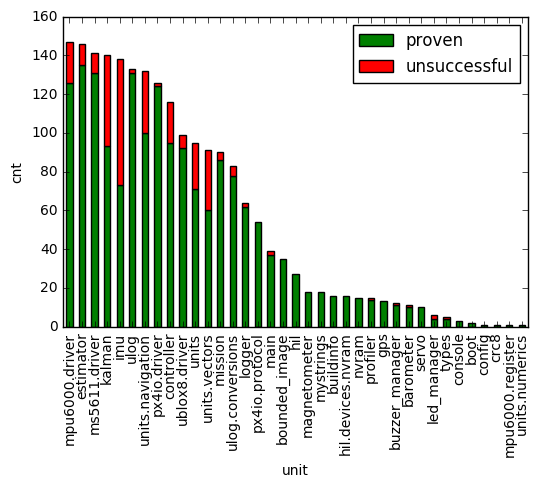

In [6]:
unit_cnt = {k : { 'proven' : v['proven'], 'unsuccessful' : v['props'] - v['proven'], 'cnt':v['props'], 'success' : 100.0 if v['props']==0 else (100.0*v['proven'])/v['props']} for k,v in units.iteritems() if v['props']>0}
df_ucnt = pd.DataFrame(unit_cnt).T
# filter those where cnt=0


print df_ucnt.head()
df_ucnt.sort_values(by=['cnt','proven'], inplace=True, ascending=False)
exclude_columns=['cnt','success']

ax=df_ucnt.ix[df_ucnt.cnt>0,df_ucnt.columns.difference(exclude_columns)].plot.bar(stacked=True,color=['green','red']);              
ax.set_ylabel('cnt')
ax.set_xlabel('unit')
plt.savefig(FOLDER + os.sep + 'units_props.pdf', bbox_inches='tight')
plt.show()

## Failure Ratio does not depend on #props:

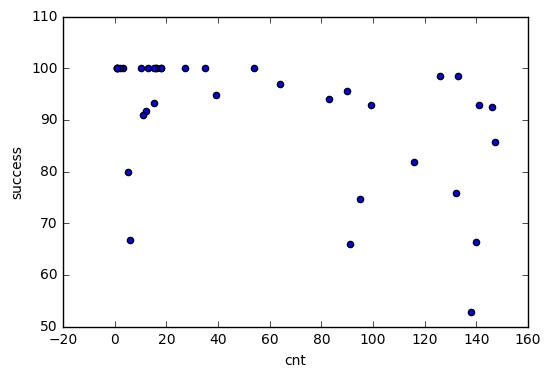

In [7]:
df_ucnt.plot.scatter(x='cnt', y='success');
plt.show()

## Coverage per Unit
Show that HAL/BSP are just spec and app is full SPARK
TODO: Units which have SPARK-Mode off in spec -> they do not appear here, which is unfair

### SPARK_Mode
Tri-state:
 * On (Must be in SPARK)
 * Off (forbid GNATprove to analyze this)
 * Auto (implicit: take whatever is compliant to SPARK as SPARK; ignore rest)

### What does "spec" mean?
Does it mean that there is a contract, or only that the spec is in a scope with SPARK mode on?

### Mixed Unit
Does it count non-SPARK subs in the body?

### Non-SPARK Unit
Does GNATprove count the specs even? 
 * yes, but only SPARK-compliant specs. E.g., it skips functions with side effects   
 * FAT_Filesystem.Directories: lot of functions. Ents=0
 
We need to count entities ourselves, somehow.



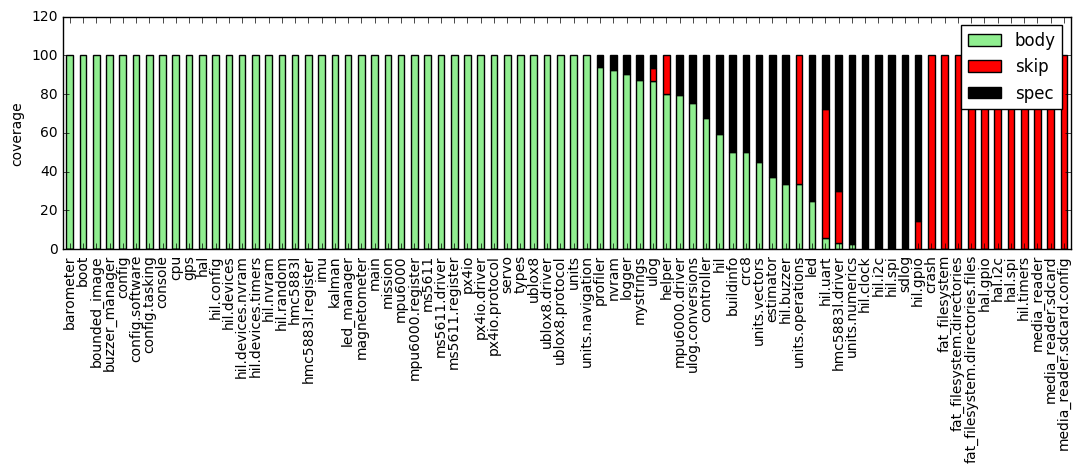

{u'body': 0, u'flows_proven': 0, u'success': 100.0, u'rules': {}, u'skip': 30, u'flows_success': 100.0, u'proven': 0, u'ents': 30, u'suppressed': 0, u'flows': 0, u'coverage': 0.0, u'props': 0, u'flows_suppressed': 0, u'spec': 0}


In [8]:
filter=['stm32','cortex','generic']#,'hil.','driver','hal','register']
unit_cov = {u : {'body': v["coverage"], 'spec': 100.0*v['spec'] / v['ents'] if v['ents'] > 0 else 0, 'ents' : v['ents'], 'skip': 100.0*v['skip']/v['ents']} for u,v in units.iteritems() if (not any(f in u for f in filter) and v['ents']>0)}
df_ucov = pd.DataFrame(unit_cov).T
df_ucov.sort_values(by=['body','spec','skip'], inplace=True, ascending=False)
exclude_columns=['ents']

ax=df_ucov.ix[:,df_ucov.columns.difference(exclude_columns)].plot.bar(stacked=True,figsize=(13,3),color=["lightgreen", "red", "black"]);
ax.set_ylabel('coverage')
plt.savefig(FOLDER + os.sep + 'units_cov.pdf', bbox_inches='tight')
plt.show()
print units["fat_filesystem.directories"]


## Flows by unit

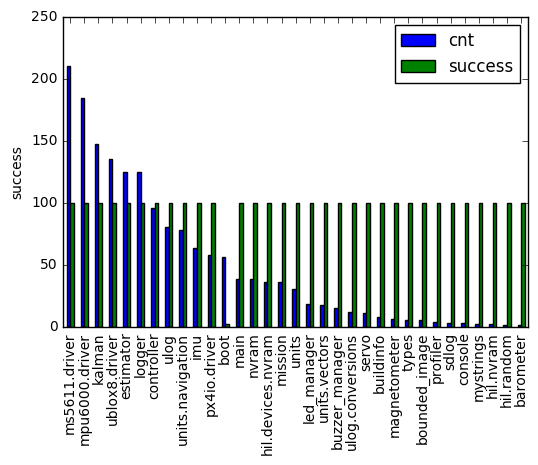

In [9]:
filter=['stm32','cortex','generic']
unit_flow = {u : {'cnt': v['flows'], 'success': v['flows_success'] } for u,v in units.iteritems() if (not any(f in u for f in filter) and v['flows']>0)}
df_flows = pd.DataFrame(unit_flow).T
df_flows.sort_values(by=['cnt'], inplace=True, ascending=False)
exclude_columns=[]
ax=df_flows.ix[:,df_flows.columns.difference(exclude_columns)].plot.bar();
ax.set_ylabel('success')
plt.show()

## by task? not yet possible